In [2]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Load data
data = pd.read_csv("C:/Users/navee/Desktop/sikandar/FYP/Skin Care/model/RGB_Dermnet.csv")

# Filter rows with labels less than or equal to 8
filtered_df = data[data['label'] <= 15]

# Save the filtered data to a new CSV file
filtered_df.to_csv("filtered_data.csv", index=False)

In [3]:
df = pd.read_csv("C:/Users/navee/Desktop/sikandar/FYP/Skin Care/model/filtered_data.csv")

In [4]:
'''# Define class names
classes = {
    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
    1: ('bcc', 'basal cell carcinoma'),
    2: ('bkl', 'benign keratosis-like lesions'),
    3: ('df', 'dermatofibroma'),
    4: ('nv', 'melanocytic nevi'),
    5: ('vasc', 'pyogenic granulomas and hemorrhage'),
    6: ('mel', 'melanoma'),
    7: ('Hives', 'Urticaria'),
    8: ('Scabies', 'Lyme Disease and other Infestations and Bites'),
    9: ('Bullous Pemphigoid', ''),
    10: ('Nail Fungus', ''),
    11: ('acne', 'Rosacea'),
    12: ('Vascular Tumor', ''),
    13: ('Vasculitis', ''),
    14: ('Pigmentation Disorder', ''),
    15: ('STDs', 'Herpes/AIDS')
}
'''

"# Define class names\nclasses = {\n    0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),\n    1: ('bcc', 'basal cell carcinoma'),\n    2: ('bkl', 'benign keratosis-like lesions'),\n    3: ('df', 'dermatofibroma'),\n    4: ('nv', 'melanocytic nevi'),\n    5: ('vasc', 'pyogenic granulomas and hemorrhage'),\n    6: ('mel', 'melanoma'),\n    7: ('Hives', 'Urticaria'),\n    8: ('Scabies', 'Lyme Disease and other Infestations and Bites'),\n    9: ('Bullous Pemphigoid', ''),\n    10: ('Nail Fungus', ''),\n    11: ('acne', 'Rosacea'),\n    12: ('Vascular Tumor', ''),\n    13: ('Vasculitis', ''),\n    14: ('Pigmentation Disorder', ''),\n    15: ('STDs', 'Herpes/AIDS')\n}\n"

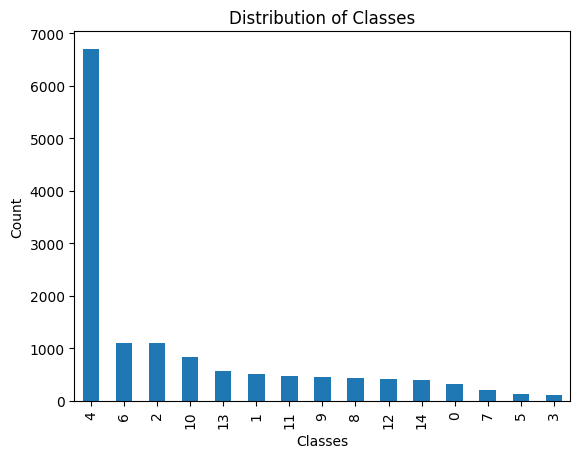

In [5]:
# EDA
distribution = df['label'].value_counts()
distribution.plot.bar()
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

In [6]:
# Fix data imbalance
sampler = RandomOverSampler()
XData, yData = sampler.fit_resample(df.drop(columns=['label']), df['label'])

In [7]:
# Reshape data
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255

In [8]:
# Create train and validation sets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData, yData, test_size=0.2)

In [9]:
# Define model
img_width, img_height = 28, 28
input_shape = (img_width, img_height, 3)

# Define the model
model = Sequential()

# Feature extraction block
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))  # Larger kernel for more context
model.add(Activation('relu'))
model.add(BatchNormalization())  # Improves training stability
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Feature extraction with dilated convolutions for wider receptive fields
model.add(Conv2D(256, (3, 3), dilation_rate=2, padding='same'))  # Dilated convolution
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Classification block
model.add(Flatten())
model.add(Dense(512))  # Increased dense layer size
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Regularization to prevent overfitting
model.add(Dense(15))
model.add(Activation('softmax'))

In [10]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])

In [11]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='dermnet_m2.h5',
                                               monitor='val_acc', mode='max',
                                               verbose=1)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [13]:
# Train the model
history = model.fit(Xtrain,
                    Ytrain,
                    epochs=100,
                    validation_data=(Xtest, Ytest),
                    callbacks=[callback, early_stopping])

Epoch 1/100
2514/2515 [============================>.] - ETA: 0s - loss: 1.1331 - accuracy: 0.6039
Epoch 1: saving model to dermnet_m2.h5
2515/2515 [==============================] - 260s 101ms/step - loss: 1.1330 - accuracy: 0.6039 - val_loss: 0.5982 - val_accuracy: 0.7835


c:\Users\navee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
2515/2515 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8696
Epoch 2: saving model to dermnet_m2.h5
2515/2515 [==============================] - 257s 102ms/step - loss: 0.3719 - accuracy: 0.8696 - val_loss: 0.3588 - val_accuracy: 0.8798
Epoch 3/100
2514/2515 [============================>.] - ETA: 0s - loss: 0.2291 - accuracy: 0.9190
Epoch 3: saving model to dermnet_m2.h5
2515/2515 [==============================] - 252s 100ms/step - loss: 0.2291 - accuracy: 0.9190 - val_loss: 0.4942 - val_accuracy: 0.8386
Epoch 4/100
2514/2515 [============================>.] - ETA: 0s - loss: 0.1645 - accuracy: 0.9422
Epoch 4: saving model to dermnet_m2.h5
2515/2515 [==============================] - 243s 97ms/step - loss: 0.1644 - accuracy: 0.9422 - val_loss: 0.1839 - val_accuracy: 0.9395
Epoch 5/100
2514/2515 [============================>.] - ETA: 0s - loss: 0.1414 - accuracy: 0.9496
Epoch 5: saving model to dermnet_m2.h5
2515/2515 [===========================

In [14]:
# Evaluate the model
model.evaluate(Xtrain, Ytrain)
model.evaluate(Xtest, Ytest)

629/629 [==============================] - 10s 16ms/step - loss: 0.0564 - accuracy: 0.9859


[0.05643835291266441, 0.9859309196472168]

In [15]:
# Plot loss over epochs
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

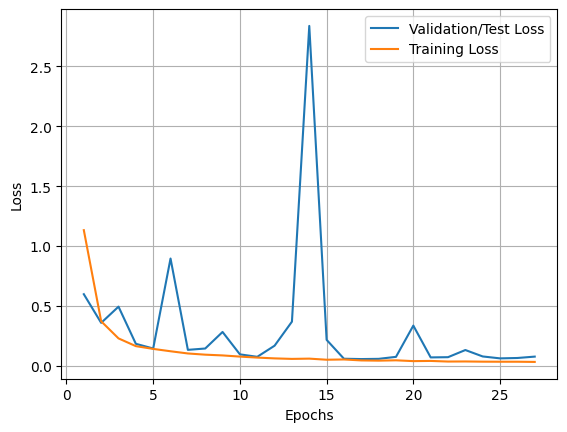

In [16]:
plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Plot accuracy over epochs
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

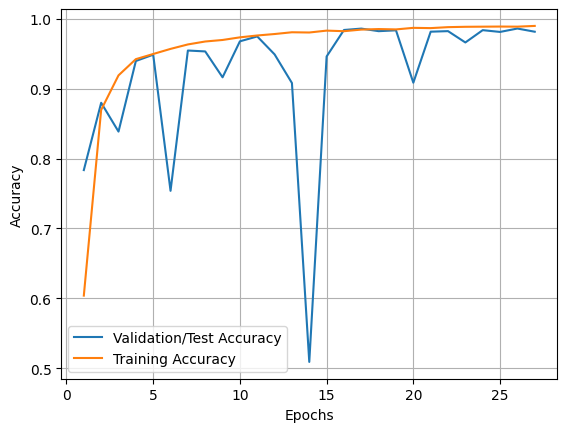

In [18]:
plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
plt.plot(epochs, acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Evaluate the model
train_loss, train_accuracy = model.evaluate(Xtrain, Ytrain)
test_loss, test_accuracy = model.evaluate(Xtest, Ytest)

629/629 [==============================] - 9s 15ms/step - loss: 0.0564 - accuracy: 0.9859


In [20]:
# Predictions
y_pred_train_probs = model.predict(Xtrain)
y_pred_test_probs = model.predict(Xtest)

629/629 [==============================] - 9s 15ms/step


In [21]:
# Convert probabilities to class labels
y_pred_train = np.argmax(y_pred_train_probs, axis=1)
y_pred_test = np.argmax(y_pred_test_probs, axis=1)

In [22]:
# Calculate F1-score
train_f1 = f1_score(Ytrain, y_pred_train, average='macro')
test_f1 = f1_score(Ytest, y_pred_test, average='macro')

In [23]:
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Train F1-score:", train_f1)

Train Loss: 0.018459908664226532
Train Accuracy: 0.9938105940818787
Train F1-score: 0.9937946580074523


In [24]:
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1-score:", test_f1)

Test Loss: 0.05643835291266441
Test Accuracy: 0.9859309196472168
Test F1-score: 0.9858687253211327


In [4]:
new_model = tf.keras.models.load_model('dermnet_m4.keras')

# Check its architecture
new_model.summary()

#Save the model into h5 format
new_model.save('dermnet_m4.h5')

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 28, 28, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_4'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']